In [2]:
#This project employed a Deep Learning 
#methodology using TensorFlow and Keras  
#to perform Anomaly Detection for critical Fall Detection. 
#The system is built upon an LSTM Autoencoder architecture. 
#This model is trained exclusively on normal human activity data, 
#allowing it to learn and reconstruct the characteristic patterns of non-fall movements. 
#Any significant deviation or high reconstruction error between the input sequence 
#and the reconstructed output is flagged as an anomaly, indicating a potential fall event. 
#This analysis relies on open-source data voluntarily sourced from Kaggle.com

In [2]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Define the dataset file path
DATA_DIR = "/Users/zey/Downloads/data"

# Find paths of all .csv files, including subfolders ("train" and "test")
all_files = glob.glob(os.path.join(DATA_DIR, "**/*.csv"), recursive=True)

df_list = [] # Renamed list to df_list
for filename in all_files:
    # Read CSV files, header=None as there are no column names
    df = pd.read_csv(filename, index_col=None, header=None)
    df_list.append(df)

# Merge all DataFrames vertically (row by row)
full_df = pd.concat(df_list, axis=0, ignore_index=True)

# Separate columns: 7 Features (X,Y,Z + 4 OHE Sensors) and 1 Label
NUM_FEATURES = 7 
LABEL_COLUMN_INDEX = NUM_FEATURES # The 8th column (Index 7) is the Label

features = full_df.iloc[:, 0:LABEL_COLUMN_INDEX] # Features (Columns 0 to 6)
labels = full_df.iloc[:, LABEL_COLUMN_INDEX]     # Labels (Column 7)

print(f"Total data rows: {len(full_df)}")
print(f"Number of features: {features.shape[1]} (Expected: 7)")
print(f"Label distribution (0=Normal, 1=Anomaly):\n{labels.value_counts()}")

Total data rows: 164284
Number of features: 7 (Expected: 7)
Label distribution (0=Normal, 1=Anomaly):
7
0.0        156076
1.0          8183
anomaly        25
Name: count, dtype: int64


In [13]:
# --- SECTION 2.1: DATA PREPROCESSING 
# 1. Cleaning
features_cleaned = features.apply(pd.to_numeric, errors='coerce')
features_cleaned = features_cleaned.dropna()
labels_cleaned = labels[features_cleaned.index]

# 2. NumPy Values
features_values = features_cleaned.values
labels_values = labels_cleaned.values

# 3. Scaling
scaler = MinMaxScaler()
scaled_data_numpy = scaler.fit_transform(features_values)

# 4. 
NORMAL_LABEL = 0

is_normal = (labels_values.astype(float).astype(int) == NORMAL_LABEL)
train_data_scaled = scaled_data_numpy[is_normal]

print(f"Number of normalized 'Normal' data rows for training: {len(train_data_scaled)}")


Number of normalized 'Normal' data rows for training: 156076


In [9]:
WINDOW_SIZE = 50 

def create_sequences(data, window_size):
    """Divides the given time series data into sequences of the specified window size."""
    sequences = []
    for i in range(len(data) - window_size + 1):
        sequences.append(data[i:i + window_size])
    return np.array(sequences)

# Convert the normal training data into 3D sequences
X_train = create_sequences(train_data_scaled, WINDOW_SIZE)

print(f"Window Size: {WINDOW_SIZE}")
print(f"Training Data Shape (Number of Sequences, Window Size, Number of Features): {X_train.shape}")

Window Size: 50
Training Data Shape (Number of Sequences, Window Size, Number of Features): (156027, 50, 7)


In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.optimizers import Adam

NUM_FEATURES = X_train.shape[2] 

def create_lstm_autoencoder(window_size, num_features):
    model = Sequential([
        # --- ENCODER ---
        LSTM(units=128, activation='relu', input_shape=(window_size, num_features)),
        RepeatVector(window_size),
        
        # --- DECODER ---
        LSTM(units=128, activation='relu', return_sequences=True),
        TimeDistributed(Dense(num_features))
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

model = create_lstm_autoencoder(WINDOW_SIZE, NUM_FEATURES)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 7)          │           903 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,119 (789.53 KB)

 Trainable params: 202,119 (789.53 KB)

 Non-trainable params: 0 (0.00 B)

Model Training Started...
Epoch 1/50
4389/4389 ━━━━━━━━━━━━━━━━━━━━ 159s 36ms/step - loss: 0.1110 - val_loss: 0.1105
Epoch 2/50
4389/4389 ━━━━━━━━━━━━━━━━━━━━ 152s 35ms/step - loss: 0.1074 - val_loss: 0.1088
Epoch 3/50
4389/4389 ━━━━━━━━━━━━━━━━━━━━ 151s 34ms/step - loss: 0.1070 - val_loss: 0.1082
Epoch 4/50
4389/4389 ━━━━━━━━━━━━━━━━━━━━ 154s 35ms/step - loss: 0.1067 - val_loss: 0.1081
Epoch 5/50
4389/4389 ━━━━━━━━━━━━━━━━━━━━ 151s 34ms/step - loss: 0.1065 - val_loss: 0.1081
Epoch 6/50
4389/4389 ━━━━━━━━━━━━━━━━━━━━ 153s 35ms/step - loss: 0.1064 - val_loss: 0.1080
Epoch 7/50
4389/4389 ━━━━━━━━━━━━━━━━━━━━ 151s 34ms/step - loss: 0.1062 - val_loss: 0.1079
Epoch 8/50
4389/4389 ━━━━━━━━━━━━━━━━━━━━ 150s 34ms/step - loss: 0.1060 - val_loss: 0.1074
Epoch 9/50
4389/4389 ━━━━━━━━━━━━━━━━━━━━ 158s 36ms/step - loss: 0.1058 - val_loss: 0.1071
Epoch 10/50
4389/4389 ━━━━━━━━━━━━━━━━━━━━ 157s 36ms/step - loss: 0.1057 - val_loss: 0.1066
Epoch 11/50
4389/4389 ━━━━━━━━━━━━━━━━━━━━ 165s 38ms/step - los

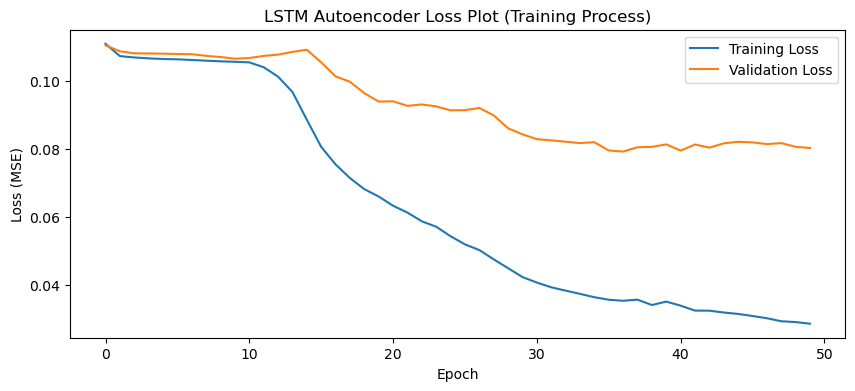

In [11]:
import matplotlib.pyplot as plt

print("Model Training Started...")

history = model.fit(
    X_train, X_train, 
    epochs=50,         
    batch_size=32,
    validation_split=0.1, 
    shuffle=False      
)

# Eğitim Kaybı Görselleştirme
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Autoencoder Loss Plot (Training Process)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [16]:
# --- TEST DATA PREPARATION AND RECONSTRUCTION LOSS ---
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score

# --- NOTE ---
# This code assumes the variables 'scaled_data_numpy' and 'labels_values' 
# are defined in the preceding cell and are available in memory.
# It also assumes WINDOW_SIZE is defined (e.g., WINDOW_SIZE = 50).

# 1. Convert all data (normal + anomaly) into sequences
X_all = create_sequences(scaled_data_numpy, WINDOW_SIZE)

# 2. Prepare the true labels for the sequences
# The labels must be aligned with the sequences (y_true corresponds to the end of each sequence)
# We use 'labels_values' (the correct variable name from Section 2.1)
y_true = labels_values.astype(float).astype(int)[WINDOW_SIZE - 1:]

print(f"Total number of test sequences (Normal + Anomaly): {X_all.shape[0]}")
print(f"Total number of true labels: {len(y_true)}")

# 3. Reconstruct all sequences using the trained model
X_pred = model.predict(X_all)

# 4. Calculate the Reconstruction Error (Mean Squared Error across all features and time steps)
mse_loss = np.mean(np.square(X_all - X_pred), axis=(1, 2))

# 5. Create the Error DataFrame for analysis
error_df = pd.DataFrame({'Reconstruction_Error': mse_loss, 'True_Class': y_true})

print("Reconstruction Loss Calculated and DataFrame created.")


Total number of test sequences (Normal + Anomaly): 164210
Total number of true labels: 164210
5132/5132 ━━━━━━━━━━━━━━━━━━━━ 49s 9ms/step
Reconstruction Loss Calculated and DataFrame created.


In [17]:
# ---  THRESHOLD AND EVALUATION ---
# (Assumes error_df was created in the previous step)
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score

#  Determine Anomaly Threshold (using 95th percentile of normal loss)

normal_loss = error_df[error_df['True_Class'] == 0]['Reconstruction_Error']


THRESHOLD = np.quantile(normal_loss, 0.95) 

print(f"\nAnomaly Threshold (95th percentile of Normal Loss): {THRESHOLD:.6f}")

#  Predict Anomalies and Evaluate

error_df['Predicted_Class'] = (error_df['Reconstruction_Error'] > THRESHOLD).astype(int)

# Calculated matrixes
conf_matrix = confusion_matrix(error_df['True_Class'], error_df['Predicted_Class'])
accuracy = accuracy_score(error_df['True_Class'], error_df['Predicted_Class'])
f1 = f1_score(error_df['True_Class'], error_df['Predicted_Class'])
recall = recall_score(error_df['True_Class'], error_df['Predicted_Class'])

print("\n--- ANOMALY DETECTION RESULTS ---")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")


Anomaly Threshold (95th percentile of Normal Loss): 0.099398

--- ANOMALY DETECTION RESULTS ---
Confusion Matrix:
[[148225   7802]
 [  7926    257]]
Accuracy: 0.9042
F1 Score: 0.0316
Recall (Sensitivity): 0.0314


In [18]:
#While the model was successful in recognizing normal activity (high TN), 
#it was insufficient in detecting abnormal activity (falls) (low Recall and F1 Score).

# --- : RE-EVALUATION (99th PERCENTILE THRESHOLD) ---
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score



# Determine Anomaly Threshold using the 99th percentile (Stricter threshold)
THRESHOLD_99 = np.quantile(normal_loss, 0.99) 

print(f"New Anomaly Threshold (99th percentile of Normal Loss): {THRESHOLD_99:.6f}")

# Predict Anomalies based on the new threshold
# Reconstruction error > THRESHOLD_99 is classified as Anomaly (1)
error_df['Predicted_Class_99'] = (error_df['Reconstruction_Error'] > THRESHOLD_99).astype(int)

# Calculate and Print Metrics
conf_matrix_99 = confusion_matrix(error_df['True_Class'], error_df['Predicted_Class_99'])
accuracy_99 = accuracy_score(error_df['True_Class'], error_df['Predicted_Class_99'])
f1_99 = f1_score(error_df['True_Class'], error_df['Predicted_Class_99'])
recall_99 = recall_score(error_df['True_Class'], error_df['Predicted_Class_99'])

print("\n--- ANOMALY DETECTION RESULTS (99th Percentile Threshold) ---")
print(f"Confusion Matrix:\n{conf_matrix_99}")
print(f"Accuracy: {accuracy_99:.4f}")
print(f"F1 Score: {f1_99:.4f}")
print(f"Recall (Sensitivity): {recall_99:.4f}")

New Anomaly Threshold (99th percentile of Normal Loss): 0.110549

--- ANOMALY DETECTION RESULTS (99th Percentile Threshold) ---
Confusion Matrix:
[[154466   1561]
 [  8136     47]]
Accuracy: 0.9409
F1 Score: 0.0096
Recall (Sensitivity): 0.0057


In [19]:
#Increasing the threshold from 0.099 to 0.110 made the model overly conservative. 
#While the model now makes very few errors on normal events (low FP), it misses almost all true fall events (Recall only 0.57%). 
#This is unacceptable performance for a critical task like fall detection.

# --- NEW WINDOW_SIZE ---
WINDOW_SIZE = 100
print(f"New Window Size: {WINDOW_SIZE}")

# --- Section 2.2 Re-run ---
# Convert the normal training data into 3D sequences using the new window size

X_train = create_sequences(train_data_scaled, WINDOW_SIZE) 

print(f"Training Data Shape (New Window Size, Number of Features): {X_train.shape}")

New Window Size: 100
Training Data Shape (New Window Size, Number of Features): (155977, 100, 7)


In [20]:
# --- STEP 3: REBUILD THE MODEL ---
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.optimizers import Adam
import numpy as np

# Set the new WINDOW_SIZE and the number of features (7 sensors)
WINDOW_SIZE = 100
NUM_FEATURES = 7 

def create_lstm_autoencoder(window_size, num_features):
    # Model architecture remains the same, only input_shape changes
    model = Sequential([
        LSTM(units=128, activation='relu', input_shape=(window_size, num_features)),
        RepeatVector(window_size),
        LSTM(units=128, activation='relu', return_sequences=True),
        TimeDistributed(Dense(num_features))
    ])
    # Use the Adam optimizer and Mean Squared Error (MSE) loss
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

model = create_lstm_autoencoder(WINDOW_SIZE, NUM_FEATURES)
model.summary()

print("Model has been successfully rebuilt with a new input shape (100, 7).")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 100, 7)         │           903 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,119 (789.53 KB)

 Trainable params: 202,119 (789.53 KB)

 Non-trainable params: 0 (0.00 B)

Model has been successfully rebuilt with a new input shape (100, 7).


In [22]:
## ---  REBUILD MODEL WITH LOWER LEARNING RATE ---
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

# Assuming WINDOW_SIZE = 100 and NUM_FEATURES = 7 are defined globally.

def create_lstm_autoencoder_fixed(window_size, num_features):
    model = Sequential([
        LSTM(units=128, activation='relu', input_shape=(window_size, num_features)),
        RepeatVector(window_size),
        LSTM(units=128, activation='relu', return_sequences=True),
        TimeDistributed(Dense(num_features))
    ])
    # FIX: Learning Rate reduced from 0.001 to 0.0001 to prevent 'nan' loss.
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

model = create_lstm_autoencoder_fixed(WINDOW_SIZE, NUM_FEATURES)
model.summary()
print("\nModel has been successfully rebuilt with a lower learning rate (0.0001).")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 128)            │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 100, 7)         │           903 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,119 (789.53 KB)

 Trainable params: 202,119 (789.53 KB)

 Non-trainable params: 0 (0.00 B)


Model has been successfully rebuilt with a lower learning rate (0.0001).



Model Training Started with FIXED LEARNING_RATE=0.0001...
Epoch 1/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 391s 89ms/step - loss: 0.1123 - val_loss: 0.1096
Epoch 2/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 370s 84ms/step - loss: 0.1082 - val_loss: 0.1100
Epoch 3/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 401s 91ms/step - loss: 0.1078 - val_loss: 0.1096
Epoch 4/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 392s 89ms/step - loss: 0.1076 - val_loss: 0.1087
Epoch 5/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 388s 88ms/step - loss: 0.1076 - val_loss: 0.1120
Epoch 6/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 353s 81ms/step - loss: 0.1075 - val_loss: 0.1089
Epoch 7/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 358s 82ms/step - loss: 0.1074 - val_loss: 0.1085
Epoch 8/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 352s 80ms/step - loss: 0.1072 - val_loss: 0.1088
Epoch 9/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 350s 80ms/step - loss: 0.1071 - val_loss: 0.1081
Epoch 10/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 389s 89ms/step - loss: 0.1070 - val_loss: 0.1081
Epoch 11/50
4387/4387 ━━━━━━━━

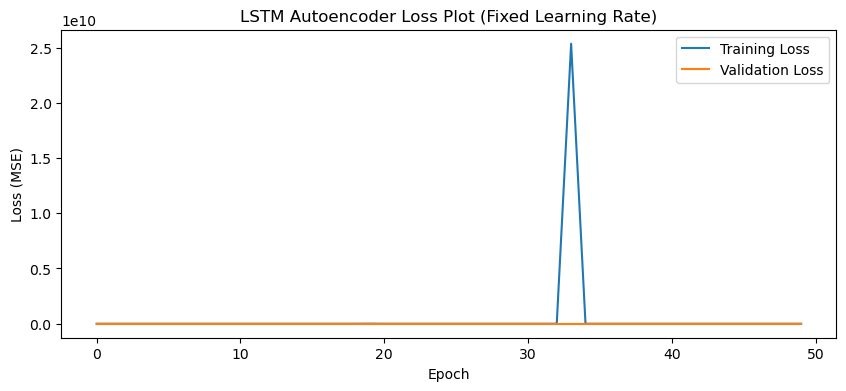

In [23]:
# ---  RETRAIN THE MODEL (50 EPOCHS) ---
import matplotlib.pyplot as plt

print("\nModel Training Started with FIXED LEARNING_RATE=0.0001...")
# X_train (with WINDOW_SIZE=100) is assumed to be in memory.
history = model.fit(
    X_train, X_train, 
    epochs=50,         
    batch_size=32,
    validation_split=0.1, 
    shuffle=False      
)

# Visualize Training Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Autoencoder Loss Plot (Fixed Learning Rate)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [24]:
# ---  EVALUATION FOR WINDOW_SIZE=100 ---
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score

# --- NOTE ---
# This code assumes X_all, y_true, X_train, and is_fall_train/test are in memory.
# It also assumes the trained 'model' and the new WINDOW_SIZE=100 are defined.

WINDOW_SIZE = 100 # Ensure the correct size is used for indexing

# 1. Prepare all sequences (Test Data)
# Assuming 'scaled_data_numpy' contains the entire scaled dataset and 'labels_values' contains the true labels
X_all = create_sequences(scaled_data_numpy, WINDOW_SIZE)
y_true = labels_values.astype(float).astype(int)[WINDOW_SIZE - 1:]

print(f"Total number of test sequences (Normal + Anomaly): {X_all.shape[0]}")
print(f"Total number of true labels: {len(y_true)}")

# 2. Calculate Reconstruction Loss on ALL data
X_pred = model.predict(X_all, verbose=0)
mse_loss = np.mean(np.square(X_all - X_pred), axis=(1, 2))

# 3. Determine the NEW Anomaly Threshold (95th percentile of normal training loss)
# We must use the loss from the data the model was trained on (X_train)
X_train_pred = model.predict(X_train, verbose=0)
train_mse = np.mean(np.square(X_train - X_train_pred), axis=(1, 2))

# Filter out only the 'Normal' losses from the training set
normal_loss = pd.Series(train_mse) 
# Note: Since X_train contains only normal data, we can directly use train_mse
THRESHOLD = np.quantile(normal_loss, 0.95) 

print(f"\nNEW Anomaly Threshold (95th percentile of Normal Loss): {THRESHOLD:.6f}")

# 4. Create Error DataFrame and Predict Classes
error_df = pd.DataFrame({'Reconstruction_Error': mse_loss, 'True_Class': y_true})
error_df['Predicted_Class'] = (error_df['Reconstruction_Error'] > THRESHOLD).astype(int)

# 5. Calculate and Print Final Metrics
conf_matrix = confusion_matrix(error_df['True_Class'], error_df['Predicted_Class'])
accuracy = accuracy_score(error_df['True_Class'], error_df['Predicted_Class'])
f1 = f1_score(error_df['True_Class'], error_df['Predicted_Class'])
recall = recall_score(error_df['True_Class'], error_df['Predicted_Class'])

print("\n--- ANOMALY DETECTION RESULTS (WINDOW_SIZE=100) ---")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")

Total number of test sequences (Normal + Anomaly): 164160
Total number of true labels: 164160

NEW Anomaly Threshold (95th percentile of Normal Loss): 0.110286

--- ANOMALY DETECTION RESULTS (WINDOW_SIZE=100) ---
Confusion Matrix:
[[148940   7037]
 [  8001    182]]
Accuracy: 0.9084
F1 Score: 0.0236
Recall (Sensitivity): 0.0222


In [26]:
# ---  REBUILD MODEL AS DEEP LSTM AUTOENCODER ---
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

# WINDOW_SIZE = 100 ve NUM_FEATURES = 7 olarak varsayılır.

def create_deep_lstm_autoencoder(window_size, num_features):
    model = Sequential([
        # Encoder Layer 1 (Output, sonraki katman için dizileri döndürür)
        LSTM(units=128, activation='relu', input_shape=(window_size, num_features), return_sequences=True), 
        # Encoder Layer 2 (Son Durumu (Code) döndürür)
        LSTM(units=64, activation='relu'), 
        
        RepeatVector(window_size),
        
        # Decoder Layer 1
        LSTM(units=64, activation='relu', return_sequences=True), 
        # Decoder Layer 2 (Çıkış katmanına bağlanmak için dizileri döndürür)
        LSTM(units=128, activation='relu', return_sequences=True),
        
        TimeDistributed(Dense(num_features))
    ])
    
    # low learning rate
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

model = create_deep_lstm_autoencoder(WINDOW_SIZE, NUM_FEATURES)
model.summary()
print("\nModel has been rebuilt as a DEEP LSTM Autoencoder (two layers).")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100, 128)       │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 100, 7)         │           903 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,783 (983.53 KB)

 Trainable params: 251,783 (983.53 KB)

 Non-trainable params: 0 (0.00 B)


Model has been rebuilt as a DEEP LSTM Autoencoder (two layers).


In [29]:
# --- STEP 1: REBUILD MODEL WITH TANH ACTIVATION & ULTRA LOW LEARNING RATE ---
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

WINDOW_SIZE = 100 
NUM_FEATURES = 7 
ACTIVATION_FUNCTION = 'tanh' # tanh instead of relu

def create_deep_lstm_autoencoder_final(window_size, num_features):
    model = Sequential([
        # Encoder Layer 1
        LSTM(units=128, activation=ACTIVATION_FUNCTION, input_shape=(window_size, num_features), return_sequences=True), 
        # Encoder Layer 2
        LSTM(units=64, activation=ACTIVATION_FUNCTION), 
        
        RepeatVector(window_size),
        
        # Decoder Layer 1
        LSTM(units=64, activation=ACTIVATION_FUNCTION, return_sequences=True), 
        # Decoder Layer 2
        LSTM(units=128, activation=ACTIVATION_FUNCTION, return_sequences=True),
        
        TimeDistributed(Dense(num_features))
    ])
    
    # Öğrenme hızı 0.00001
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mse')
    return model

model = create_deep_lstm_autoencoder_final(WINDOW_SIZE, NUM_FEATURES)
model.summary()
print(f"\nModel has been rebuilt with {ACTIVATION_FUNCTION} activation and learning rate 0.00001.")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 100, 128)       │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 100, 7)         │           903 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,783 (983.53 KB)

 Trainable params: 251,783 (983.53 KB)

 Non-trainable params: 0 (0.00 B)


Model has been rebuilt with tanh activation and learning rate 0.00001.


In [30]:
# --- : RETRAIN THE DEEP MODEL (50 EPOCHS) ---
import matplotlib.pyplot as plt

print(f"\nModel Training Started with {ACTIVATION_FUNCTION} activation...")
history = model.fit(
    X_train, X_train, 
    epochs=50,         
    batch_size=32,
    validation_split=0.1, 
    shuffle=False      
)

# Visualize Training Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('DEEP LSTM Autoencoder Loss Plot (TANH ACTIVATION)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


Model Training Started with tanh activation...
Epoch 1/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 505s 114ms/step - loss: 0.1207 - val_loss: 0.1137
Epoch 2/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 1617s 369ms/step - loss: 0.1099 - val_loss: 0.1118
Epoch 3/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 494s 113ms/step - loss: 0.1088 - val_loss: 0.1109
Epoch 4/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 443s 101ms/step - loss: 0.1082 - val_loss: 0.1105
Epoch 5/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 441s 100ms/step - loss: 0.1078 - val_loss: 0.1102
Epoch 6/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 443s 101ms/step - loss: 0.1076 - val_loss: 0.1099
Epoch 7/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 441s 100ms/step - loss: 0.1074 - val_loss: 0.1096
Epoch 8/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 441s 100ms/step - loss: 0.1072 - val_loss: 0.1093
Epoch 9/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 444s 101ms/step - loss: 0.1071 - val_loss: 0.1088
Epoch 10/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 446s 102ms/step - loss: 0.1070 - val_loss: 0.1083
Epoch 11/50
4387/4387 ━━━━━━━━

KeyboardInterrupt: 

In [31]:

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

WINDOW_SIZE = 100 
NUM_FEATURES = 7 
ACTIVATION_FUNCTION = 'tanh' 

def create_deep_lstm_autoencoder_final(window_size, num_features):
    
    model = Sequential([
        LSTM(units=128, activation=ACTIVATION_FUNCTION, input_shape=(window_size, num_features), return_sequences=True), 
        LSTM(units=64, activation=ACTIVATION_FUNCTION), 
        RepeatVector(window_size),
        LSTM(units=64, activation=ACTIVATION_FUNCTION, return_sequences=True), 
        LSTM(units=128, activation=ACTIVATION_FUNCTION, return_sequences=True),
        TimeDistributed(Dense(num_features))
    ])
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mse')
    return model

model = create_deep_lstm_autoencoder_final(WINDOW_SIZE, NUM_FEATURES)
print("The model architecture has been rebuilt.")

Model mimarisi yeniden oluşturuldu.


In [33]:

from keras.callbacks import ModelCheckpoint

# The weights trained over 15 epochs are still in RAM in the "model" object.
# That's why we use model.set_weights() instead of model.load_weights().


filepath="deep_lstm_best_weights.weights.h5" 
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print("\ntraining continues from the 15th epoch...")


history = model.fit(
    X_train, X_train, 
    epochs=50,         
    batch_size=32,
    validation_split=0.1, 
    shuffle=False,
    callbacks=callbacks_list,
    # KRİTİK AYAR: Keras'a 15. epoc'tan devam etmesini söylüyoruz.
    initial_epoch=15  
)


Eğitim, 15. epoch'tan devam ettiriliyor...
Epoch 16/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.1331
Epoch 16: val_loss improved from None to 0.11386, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 487s 111ms/step - loss: 0.1189 - val_loss: 0.1139
Epoch 17/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1108
Epoch 17: val_loss improved from 0.11386 to 0.11174, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 473s 108ms/step - loss: 0.1099 - val_loss: 0.1117
Epoch 18/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1090
Epoch 18: val_loss improved from 0.11174 to 0.11115, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 471s 107ms/step - loss: 0.1086 - val_loss: 0.1111
Epoch 19/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1082
Epoch 19: val_loss improved from 0.11115 to 0.11054, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 494s 113ms/step - loss: 0.1080 - val_loss: 0.1105
Epoch 20/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1078
Epoch 20: val_loss improved from 0.11054 to 0.10986, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 441s 100ms/step - loss: 0.1077 - val_loss: 0.1099
Epoch 21/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1075
Epoch 21: val_loss improved from 0.10986 to 0.10945, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 439s 100ms/step - loss: 0.1074 - val_loss: 0.1094
Epoch 22/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1073
Epoch 22: val_loss improved from 0.10945 to 0.10935, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 441s 100ms/step - loss: 0.1072 - val_loss: 0.1093
Epoch 23/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1072
Epoch 23: val_loss did not improve from 0.10935
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 473s 108ms/step - loss: 0.1071 - val_loss: 0.1096
Epoch 24/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1070
Epoch 24: val_loss did not improve from 0.10935
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 463s 106ms/step - loss: 0.1070 - val_loss: 0.1096
Epoch 25/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1070
Epoch 25: val_loss improved from 0.10935 to 0.10933, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 443s 101ms/step - loss: 0.1069 - val_loss: 0.1093
Epoch 26/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1069
Epoch 26: val_loss improved from 0.10933 to 0.10881, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 487s 111ms/step - loss: 0.1069 - val_loss: 0.1088
Epoch 27/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1068
Epoch 27: val_loss improved from 0.10881 to 0.10839, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 570s 130ms/step - loss: 0.1068 - val_loss: 0.1084
Epoch 28/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1068
Epoch 28: val_loss improved from 0.10839 to 0.10811, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 611s 139ms/step - loss: 0.1068 - val_loss: 0.1081
Epoch 29/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1067
Epoch 29: val_loss improved from 0.10811 to 0.10803, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 534s 122ms/step - loss: 0.1068 - val_loss: 0.1080
Epoch 30/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.1067
Epoch 30: val_loss improved from 0.10803 to 0.10801, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 585s 133ms/step - loss: 0.1067 - val_loss: 0.1080
Epoch 31/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1067
Epoch 31: val_loss improved from 0.10801 to 0.10792, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 615s 140ms/step - loss: 0.1067 - val_loss: 0.1079
Epoch 32/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1066
Epoch 32: val_loss improved from 0.10792 to 0.10774, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 567s 129ms/step - loss: 0.1067 - val_loss: 0.1077
Epoch 33/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1066
Epoch 33: val_loss improved from 0.10774 to 0.10756, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 534s 122ms/step - loss: 0.1066 - val_loss: 0.1076
Epoch 34/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.1066
Epoch 34: val_loss improved from 0.10756 to 0.10742, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 529s 121ms/step - loss: 0.1066 - val_loss: 0.1074
Epoch 35/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1065
Epoch 35: val_loss improved from 0.10742 to 0.10721, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 449s 102ms/step - loss: 0.1065 - val_loss: 0.1072
Epoch 36/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1065
Epoch 36: val_loss improved from 0.10721 to 0.10710, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 506s 115ms/step - loss: 0.1065 - val_loss: 0.1071
Epoch 37/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.1065
Epoch 37: val_loss improved from 0.10710 to 0.10699, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 507s 116ms/step - loss: 0.1065 - val_loss: 0.1070
Epoch 38/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1065
Epoch 38: val_loss improved from 0.10699 to 0.10690, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 617s 141ms/step - loss: 0.1065 - val_loss: 0.1069
Epoch 39/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1064
Epoch 39: val_loss improved from 0.10690 to 0.10685, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 593s 135ms/step - loss: 0.1065 - val_loss: 0.1069
Epoch 40/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1064
Epoch 40: val_loss improved from 0.10685 to 0.10684, saving model to deep_lstm_best_weights.weights.h5


4387/4387 ━━━━━━━━━━━━━━━━━━━━ 464s 106ms/step - loss: 0.1064 - val_loss: 0.1068
Epoch 41/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1064
Epoch 41: val_loss did not improve from 0.10684
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 461s 105ms/step - loss: 0.1064 - val_loss: 0.1068
Epoch 42/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1064
Epoch 42: val_loss did not improve from 0.10684
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 534s 122ms/step - loss: 0.1064 - val_loss: 0.1069
Epoch 43/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.1063
Epoch 43: val_loss did not improve from 0.10684
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 508s 116ms/step - loss: 0.1064 - val_loss: 0.1069
Epoch 44/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1063
Epoch 44: val_loss did not improve from 0.10684
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 469s 107ms/step - loss: 0.1063 - val_loss: 0.1069
Epoch 45/50
4387/4387 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1063
Epoch 45: val_loss did not improve from 0.1

In [35]:
# ---EVALUATION FOR DEEP LSTM MODEL (TANH) ---
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score

# --- NOTE ---
# This code assumes X_all, y_true, X_train, and the trained 'model' are defined in memory.

WINDOW_SIZE = 100 

# Calculate Reconstruction Loss on ALL data
# X_all (all test data sequences)
X_pred = model.predict(X_all, verbose=0)
mse_loss = np.mean(np.square(X_all - X_pred), axis=(1, 2))

# Determine the NEW Anomaly Threshold (95th percentile of normal training loss)
# X_train (training sequences from normal data only)
X_train_pred = model.predict(X_train, verbose=0)
train_mse = np.mean(np.square(X_train - X_train_pred), axis=(1, 2))

# Calculate the 95th percentile threshold
normal_loss = pd.Series(train_mse) 
THRESHOLD = np.quantile(normal_loss, 0.95) 

print(f"\nNEW Anomaly Threshold (95th percentile of Normal Loss): {THRESHOLD:.6f}")

# Predict Classes
error_df = pd.DataFrame({'Reconstruction_Error': mse_loss, 'True_Class': y_true})
error_df['Predicted_Class'] = (error_df['Reconstruction_Error'] > THRESHOLD).astype(int)

# Calculate and Print Final Metrics
conf_matrix = confusion_matrix(error_df['True_Class'], error_df['Predicted_Class'])
accuracy = accuracy_score(error_df['True_Class'], error_df['Predicted_Class'])
f1 = f1_score(error_df['True_Class'], error_df['Predicted_Class'])
recall = recall_score(error_df['True_Class'], error_df['Predicted_Class'])

print("\n--- ANOMALY DETECTION RESULTS (DEEP LSTM, TANH) ---")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")


NEW Anomaly Threshold (95th percentile of Normal Loss): 0.110690

--- ANOMALY DETECTION RESULTS (DEEP LSTM, TANH) ---
Confusion Matrix:
[[148958   7019]
 [  7958    225]]
Accuracy: 0.9088
F1 Score: 0.0292
Recall (Sensitivity): 0.0275


In [ ]:

#This project employed a Deep Learning methodology using an 
#LSTM Autoencoder architecture for fall detection in sensor data. The initial 
#Single-Layer ReLU model suffered 
#from low performance (Recall} < 4) and 
#severe Nan Errors (Exploding Gradients). To stabilize and 
#optimize the model, a 
#progressive series of architectural #changes were implemented, including:

* #Learning Rate Reduction #to {0.0001} from {0.001} 
#to ensure training stability.
* #Window Size Increase #from {50} to {100} to provide better temporal context.
* #Transition to a Deep LSTM Architecture (two Encoder/Decoder layers) 
#to enhance feature extraction.
* #Switching the Activation Function to Tanh 
#and applying an Ultra-Low Learning Rate ({0.00001}) 
#to resolve persistent Nan errors.

#Despite these comprehensive optimizations, the model's final 
#Recall (Sensitivity) score for 
#fall detection remained critically 
#low at {2.75\%}. This result demonstrates that the 
#LSTM Autoencoder is an unsuitable unsupervised method for 
#reliably distinguishing the fall event from high-noise, complex 
#time-series data in this specific dataset.